### Machine Learning: Summer 2020
### Project 3

# Image Classification using Tensorflow

### Anshul Dabas and Anndi Russell

## Experiment Objective

In this project, we are attempting to classify an image as either a car or a plane. We downloaded the dataset from [geeksforgeeks.org](https://www.geeksforgeeks.org/python-image-classification-using-keras/); the dataset is publically available and contains no sensitive, personal information that could be of ethical concern.

The original data was split into training and test directories, and further into cars and planes directories. This will allow us to label the images appropriately as either a car or a plane.

Our goal is that, given an image of a car or a plane, our model can accurately predict which one it is. This research could be used in a ReCaptcha to verify that you're not a robot (i.e. "Click all the images that have planes in them").

## Data Collection and Preprocessing

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import glob
from PIL import Image

##### First, we will import data and display some information and images, as well as explain each step. Then, we will wrap all of these steps in a function that will be used later.

Create paths for the cars and planes directories within the training and testing directories:

In [2]:
train_planes_path = pathlib.Path('v_data/train/planes')
train_cars_path = pathlib.Path('v_data/train/cars')

test_planes_path = pathlib.Path('v_data/test/planes')
test_cars_path = pathlib.Path('v_data/test/cars')

Make a list of the .jpg files in each directory:

In [3]:
train_planes_file_list = sorted([str(path) for path in train_planes_path.glob('*.jpg')])
train_cars_file_list = sorted([str(path) for path in train_cars_path.glob('*.jpg')])

test_planes_file_list = sorted([str(path) for path in test_planes_path.glob('*.jpg')])
test_cars_file_list = sorted([str(path) for path in test_cars_path.glob('*.jpg')])

Display the lengths of the files lists for each directory:

In [4]:
print("Training planes: ",len(train_planes_file_list))
print("Training cars: ",len(train_cars_file_list))
print("Testing planes: ",len(test_planes_file_list))
print("Testing cars: ",len(test_cars_file_list))

Training planes:  200
Training cars:  200
Testing planes:  50
Testing cars:  50


Shape and display of a sample of 6 planes images:

Image shape:  (224, 224, 3)
Image shape:  (224, 224, 3)
Image shape:  (224, 224, 3)
Image shape:  (224, 224, 3)
Image shape:  (224, 224, 3)
Image shape:  (224, 224, 3)


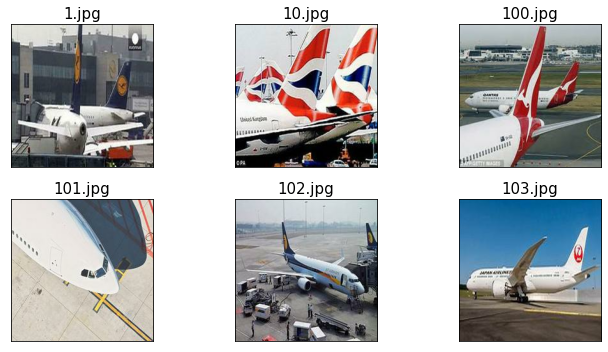

In [5]:
fig = plt.figure(figsize=(10, 5))
i=0
for i,file in enumerate(train_planes_file_list):
    img_raw = tf.io.read_file(file)
    img = tf.image.decode_image(img_raw)
    print('Image shape: ', img.shape)
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(os.path.basename(file), size=15)
    i=i+1
    if i==6:
        break
# plt.savefig('ch13-catdot-examples.pdf')
plt.tight_layout()
plt.show()

Shape and display of a sample of 6 cars images:

Image shape:  (224, 224, 3)
Image shape:  (224, 224, 3)
Image shape:  (224, 224, 3)
Image shape:  (224, 224, 3)
Image shape:  (224, 224, 3)
Image shape:  (224, 224, 3)


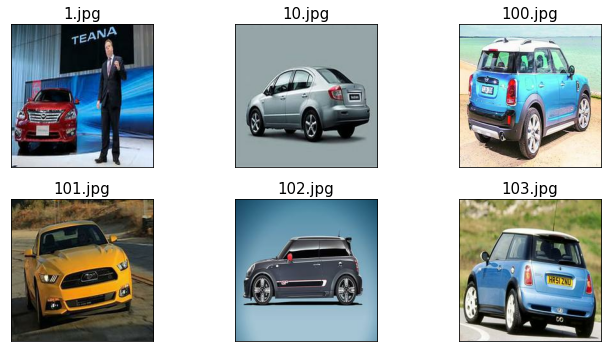

In [6]:
fig = plt.figure(figsize=(10, 5))
i=0
for i,file in enumerate(train_cars_file_list):
    img_raw = tf.io.read_file(file)
    img = tf.image.decode_image(img_raw)
    print('Image shape: ', img.shape)
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(os.path.basename(file), size=15)
    i=i+1
    if i==6:
        break
# plt.savefig('ch13-catdot-examples.pdf')
plt.tight_layout()
plt.show()

As we can see above, the images vary in composition, angle, and content. There also is a consistent shape for the images.

Create a list of labels: 1 for planes, 0 for cars:

In [7]:
train_planes_labels = [1 for file in train_planes_file_list]
train_cars_labels = [0 for file in train_cars_file_list]

test_planes_labels = [1 for file in test_planes_file_list]
test_cars_labels = [0 for file in test_cars_file_list]

Combine planes and cars files and labels for testing and training:

In [8]:
train_all_files=train_planes_file_list+train_cars_file_list
train_all_labels=train_planes_labels+train_cars_labels

test_all_files=test_planes_file_list+test_cars_file_list
test_all_labels=test_planes_labels+test_cars_labels

##### Define functions to do the data input that we did above, and decode the images. This create_train_data function will be called by input_fn with the estimator in a future step.

Function to decode images:

In [2]:
def load_and_preprocess(paths):
    images=[]
    for path in paths:
        image=tf.io.read_file(path)
        image=tf.image.decode_jpeg(image,channels=3)
        image=tf.image.resize(image,[224,224])
        image/=255.0
        images.append(image)
    return images

Function to load training data and return tensorflow dataset with decoded images to the estimator:

In [10]:
def create_train_data():
    #returns dataset of decoded images and their labels
    
    train_planes_path = pathlib.Path('v_data/train/planes')
    train_cars_path = pathlib.Path('v_data/train/cars')
    
    train_planes_file_list = sorted([str(path) for path in train_planes_path.glob('*.jpg')])
    train_cars_file_list = sorted([str(path) for path in train_cars_path.glob('*.jpg')])
    
    train_planes_labels = [1 for file in train_planes_file_list]
    train_cars_labels = [0 for file in train_cars_file_list]
    
    train_all_files=train_planes_file_list+train_cars_file_list
    train_all_labels=train_planes_labels+train_cars_labels
    
    train_all_images=load_and_preprocess(train_all_files) #decode the images
    train_all_labels=np.array(train_all_labels)
    
    ds_images_labels = tf.data.Dataset.from_tensor_slices(
        ({'input-features':train_all_images}, train_all_labels.reshape(-1, 1)))

    ds_images_labels=ds_images_labels.shuffle(buffer_size=len(train_all_labels))
    
    #print("TRAINING DATASET:",ds_images_labels)
    return ds_images_labels

Function to load validation data and return tensorflow dataset:

In [11]:
def create_valid_data():
    valid_planes_path = pathlib.Path('v_data/test/planes')
    valid_cars_path = pathlib.Path('v_data/test/cars')
    
    valid_planes_file_list = sorted([str(path) for path in valid_planes_path.glob('*.jpg')])
    valid_cars_file_list = sorted([str(path) for path in valid_cars_path.glob('*.jpg')])
    
    valid_planes_labels = [1 for file in valid_planes_file_list]
    valid_cars_labels = [0 for file in valid_cars_file_list]
    
    valid_all_files=valid_planes_file_list+valid_cars_file_list
    valid_all_labels=valid_planes_labels+valid_cars_labels
    
    valid_all_images=load_and_preprocess(valid_all_files)
    valid_all_labels=np.array(valid_all_labels)
    
    ds_images_labels_valid = tf.data.Dataset.from_tensor_slices(
        ({'input-features':valid_all_images}, valid_all_labels.reshape(-1, 1)))

    ds_images_labels_valid=ds_images_labels_valid.shuffle(buffer_size=len(valid_all_labels))
    
    #print("VALID DATASET:",ds_images_labels_valid)
    return ds_images_labels_valid

## Tensorflow Model Creation

Build model:

In [12]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Input(shape=(224,224,3), name='input-features'),
    
    tf.keras.layers.Dense(units=8,
                          activation='relu',
                          kernel_initializer=tf.keras.initializers.GlorotNormal(),
                          bias_initializer=tf.keras.initializers.Constant(0.1),
                          name='hiddenlayer1'),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Dense(units=8, 
                          activation='relu', 
                          name='hiddenlayer2',
                          kernel_initializer=tf.keras.initializers.GlorotNormal(),
                          bias_initializer=tf.keras.initializers.Constant(0.1)),
    
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Dense(units=8, 
                          activation='relu', 
                          name='hiddenlayer3',
                          kernel_initializer=tf.keras.initializers.GlorotNormal(),
                          bias_initializer=tf.keras.initializers.Constant(0.1)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(1, 
                          activation='sigmoid', 
                          activity_regularizer='l1', name="output")
    
])

model.build(input_shape=(224,224,3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hiddenlayer1 (Dense)         (None, 224, 224, 8)       32        
_________________________________________________________________
dropout (Dropout)            (None, 224, 224, 8)       0         
_________________________________________________________________
hiddenlayer2 (Dense)         (None, 224, 224, 8)       72        
_________________________________________________________________
dropout_1 (Dropout)          (None, 224, 224, 8)       0         
_________________________________________________________________
hiddenlayer3 (Dense)         (None, 224, 224, 8)       72        
_________________________________________________________________
flatten (Flatten)            (None, 401408)            0         
_________________________________________________________________
output (Dense)               (None, 1)                 4

Configure model:

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(), 
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall(),])

Define the feature columns:

In [14]:
features = [
    tf.feature_column.numeric_column(
        key='input-features:', shape=(224,224,3))
]
    
features

[NumericColumn(key='input-features:', shape=(224, 224, 3), default_value=None, dtype=tf.float32, normalizer_fn=None)]

#### Discussion of chosen parameters:

##### Configuring layers:
Activations: For the dense hidden layers we are using ReLU as the activation function. This increases efficiency of runtime, and also helps avoid the problem of vanishing gradients. We are using sigmoid for the output layer; this is a good idea because our final output will be in the range [0,1], and can be interpreted as the probability of a positive ('1') outcome.
<br>

Initializers: 
In the layers that use ReLU as the activation function, we will initialize with a slightly positive bias so we can avoid dead neurons (citation [here](https://stackoverflow.com/questions/40708169/how-to-initialize-biases-in-a-keras-model)). In these same layers, we'll initialize weights using GlorotNormal; this will break symmetry between hidden units in the same layer (cititaion [here](https://stats.stackexchange.com/questions/47590/what-are-good-initial-weights-in-a-neural-network)). 

<br>
Regularizers: We have the choice of L1 or L2 regularization when building our layers. We chose L1 in the sigmoid layer because it facilitaties compression of the model since some weights will decay to zero. We tried using L2 and our accuracy was lower (0.47); L1 was the better choice for accuracy.

<br>

##### Compiling the model:

Optimizers: We used SGD for the optimizer. We tested a few different learning rates, and 0.001 performed the best.
<br>
Loss functions: Binary cross entropy since we have binary output.
<br>
Metrics: Accuracy, precision, and recall will give us a variety of metrics to interprete, relating to both type-1 and type-2 errors.
<br>


##### Dimensions of model:

We tested 1, 2, and 3 hidden layers, and 3 hidden layers improved the accuracy of our model. We have 8 nodes in each layer.

## TensorFlow estimator creation and training

Create estimator:

In [15]:
my_estimator = tf.keras.estimator.model_to_estimator(
    keras_model=model,
    model_dir='testmodels/est3/')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
INFO:tensorflow:Using config: {'_model_dir': 'testmodels/est3/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is

Define the input function:

In [16]:
num_epochs = 200
batch_size = 2
steps_per_epoch = np.ceil(400 / batch_size)

def input_fn(batch_size=8):
    ds=create_train_data()
    return ds.shuffle(100).repeat().batch(batch_size)

def eval_input_fn(batch_size=8):
    ds=create_valid_data()
    ds= ds.shuffle(100).batch(batch_size)
    return ds  

Train the estimator:

In [17]:
my_estimator.train(
    input_fn=lambda: input_fn(batch_size),steps=num_epochs * steps_per_epoch)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='testmodels/est3/keras/keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: testmodels/est3/keras/keras_model.ckpt
INFO:tensorflow:Warm-starting variables only in TRAINABLE_VARIABLES.
INFO:tensorflow:Warm-started 8 variables.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into testmodels/est3/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving

INFO:tensorflow:global_step/sec: 40.3198
INFO:tensorflow:loss = 0.0050118617, step = 7000 (2.481 sec)
INFO:tensorflow:global_step/sec: 43.6795
INFO:tensorflow:loss = 0.027165823, step = 7100 (2.289 sec)
INFO:tensorflow:global_step/sec: 44.7752
INFO:tensorflow:loss = 0.006679847, step = 7200 (2.233 sec)
INFO:tensorflow:global_step/sec: 43.2895
INFO:tensorflow:loss = 0.019577129, step = 7300 (2.311 sec)
INFO:tensorflow:global_step/sec: 45.0084
INFO:tensorflow:loss = 0.0013114525, step = 7400 (2.221 sec)
INFO:tensorflow:global_step/sec: 43.611
INFO:tensorflow:loss = 0.027346523, step = 7500 (2.293 sec)
INFO:tensorflow:global_step/sec: 40.5421
INFO:tensorflow:loss = 0.0122704245, step = 7600 (2.467 sec)
INFO:tensorflow:global_step/sec: 45.4922
INFO:tensorflow:loss = 0.0050027734, step = 7700 (2.198 sec)
INFO:tensorflow:global_step/sec: 40.4728
INFO:tensorflow:loss = 0.012566236, step = 7800 (2.470 sec)
INFO:tensorflow:global_step/sec: 42.7422
INFO:tensorflow:loss = 0.005276992, step = 7900

INFO:tensorflow:global_step/sec: 43.382
INFO:tensorflow:loss = 0.007589886, step = 15100 (2.303 sec)
INFO:tensorflow:global_step/sec: 39.106
INFO:tensorflow:loss = 0.0050150254, step = 15200 (2.558 sec)
INFO:tensorflow:global_step/sec: 35.4795
INFO:tensorflow:loss = 0.018912436, step = 15300 (2.819 sec)
INFO:tensorflow:global_step/sec: 39.3756
INFO:tensorflow:loss = 0.011296375, step = 15400 (2.538 sec)
INFO:tensorflow:global_step/sec: 46.6147
INFO:tensorflow:loss = 0.0023851264, step = 15500 (2.145 sec)
INFO:tensorflow:global_step/sec: 42.8142
INFO:tensorflow:loss = 0.005, step = 15600 (2.336 sec)
INFO:tensorflow:global_step/sec: 46.1814
INFO:tensorflow:loss = 0.024245616, step = 15700 (2.165 sec)
INFO:tensorflow:global_step/sec: 45.2002
INFO:tensorflow:loss = 0.0050215144, step = 15800 (2.212 sec)
INFO:tensorflow:global_step/sec: 46.043
INFO:tensorflow:loss = 5.9181373e-05, step = 15900 (2.172 sec)
INFO:tensorflow:global_step/sec: 45.5803
INFO:tensorflow:loss = 0.00500095, step = 160

INFO:tensorflow:loss = 0.0050271805, step = 23100 (2.159 sec)
INFO:tensorflow:global_step/sec: 45.288
INFO:tensorflow:loss = 0.00034039892, step = 23200 (2.208 sec)
INFO:tensorflow:global_step/sec: 44.1207
INFO:tensorflow:loss = 0.0100002345, step = 23300 (2.267 sec)
INFO:tensorflow:global_step/sec: 43.351
INFO:tensorflow:loss = 0.0056140735, step = 23400 (2.307 sec)
INFO:tensorflow:global_step/sec: 45.7102
INFO:tensorflow:loss = 6.3710213e-12, step = 23500 (2.187 sec)
INFO:tensorflow:global_step/sec: 45.7349
INFO:tensorflow:loss = 0.005153971, step = 23600 (2.187 sec)
INFO:tensorflow:global_step/sec: 46.7907
INFO:tensorflow:loss = 0.0051293606, step = 23700 (2.137 sec)
INFO:tensorflow:global_step/sec: 45.8289
INFO:tensorflow:loss = 0.0056277346, step = 23800 (2.182 sec)
INFO:tensorflow:global_step/sec: 45.6191
INFO:tensorflow:loss = 0.00033458535, step = 23900 (2.192 sec)
INFO:tensorflow:global_step/sec: 44.3238
INFO:tensorflow:loss = 0.0103275515, step = 24000 (2.258 sec)
INFO:tensor

INFO:tensorflow:loss = 0.0015494295, step = 30900 (2.210 sec)
INFO:tensorflow:global_step/sec: 45.4126
INFO:tensorflow:loss = 0.0013372443, step = 31000 (2.202 sec)
INFO:tensorflow:global_step/sec: 45.9908
INFO:tensorflow:loss = 2.0138485e-05, step = 31100 (2.174 sec)
INFO:tensorflow:global_step/sec: 43.5115
INFO:tensorflow:loss = 0.0050241933, step = 31200 (2.298 sec)
INFO:tensorflow:global_step/sec: 43.769
INFO:tensorflow:loss = 0.0053903786, step = 31300 (2.285 sec)
INFO:tensorflow:global_step/sec: 45.6157
INFO:tensorflow:loss = 0.0051222015, step = 31400 (2.192 sec)
INFO:tensorflow:global_step/sec: 45.5721
INFO:tensorflow:loss = 0.005471168, step = 31500 (2.195 sec)
INFO:tensorflow:global_step/sec: 44.6933
INFO:tensorflow:loss = 0.005, step = 31600 (2.237 sec)
INFO:tensorflow:global_step/sec: 45.5942
INFO:tensorflow:loss = 0.00021273144, step = 31700 (2.193 sec)
INFO:tensorflow:global_step/sec: 45.4526
INFO:tensorflow:loss = 0.0067300093, step = 31800 (2.200 sec)
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 45.5302
INFO:tensorflow:loss = 0.001193128, step = 39000 (2.196 sec)
INFO:tensorflow:global_step/sec: 46.0075
INFO:tensorflow:loss = 0.005, step = 39100 (2.175 sec)
INFO:tensorflow:global_step/sec: 46.0707
INFO:tensorflow:loss = 0.0050001764, step = 39200 (2.170 sec)
INFO:tensorflow:global_step/sec: 46.2713
INFO:tensorflow:loss = 0.008773378, step = 39300 (2.161 sec)
INFO:tensorflow:global_step/sec: 45.1295
INFO:tensorflow:loss = 5.6293075e-06, step = 39400 (2.216 sec)
INFO:tensorflow:global_step/sec: 45.9728
INFO:tensorflow:loss = 0.0051126247, step = 39500 (2.174 sec)
INFO:tensorflow:global_step/sec: 46.8115
INFO:tensorflow:loss = 0.005, step = 39600 (2.136 sec)
INFO:tensorflow:global_step/sec: 47.4967
INFO:tensorflow:loss = 0.010155154, step = 39700 (2.106 sec)
INFO:tensorflow:global_step/sec: 46.2248
INFO:tensorflow:loss = 0.005287521, step = 39800 (2.164 sec)
INFO:tensorflow:global_step/sec: 46.7519
INFO:tensorflow:loss = 0.010036615, step = 39900 

## TensorFlow estimator performance evaluation and visualization

Evaluate the estimator on the given metrics:

In [18]:
my_estimator.evaluate(
    input_fn=lambda: eval_input_fn(batch_size))

INFO:tensorflow:Calling model_fn.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-08-24T02:52:30Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from testmodels/est3/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 1.77318s
INFO:tensorflow:Finished evaluation at 2020-08-24-02:52:32
INFO:tensorflow:Saving dict for global step 40000: binary_accuracy = 0.83, global_step = 40000, loss = 0.9647092, precision = 0.8367347, recall = 0.82
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 40000: testmodels/est3/model.ckpt-40000


{'binary_accuracy': 0.83,
 'loss': 0.9647092,
 'precision': 0.8367347,
 'recall': 0.82,
 'global_step': 40000}

Create new function to load the data, this time returning x and y as numpy arrays. This will be used in model.fit():

In [3]:
def create_train_data_separate():
    #returns arrays of decoded images and their labels
    
    train_planes_path = pathlib.Path('v_data/train/planes')
    train_cars_path = pathlib.Path('v_data/train/cars')
    
    train_planes_file_list = sorted([str(path) for path in train_planes_path.glob('*.jpg')])
    train_cars_file_list = sorted([str(path) for path in train_cars_path.glob('*.jpg')])
    
    train_planes_labels = [1 for file in train_planes_file_list]
    train_cars_labels = [0 for file in train_cars_file_list]
    
    train_all_files=train_planes_file_list+train_cars_file_list
    train_all_labels=train_planes_labels+train_cars_labels
    
    train_all_images=load_and_preprocess(train_all_files) #decode the images
    train_all_labels=np.array(train_all_labels)
    
    x_train=train_all_images
    y_train=train_all_labels
    
    return x_train, y_train

In [4]:
def create_valid_data_separate():
    valid_planes_path = pathlib.Path('v_data/test/planes')
    valid_cars_path = pathlib.Path('v_data/test/cars')
    
    valid_planes_file_list = sorted([str(path) for path in valid_planes_path.glob('*.jpg')])
    valid_cars_file_list = sorted([str(path) for path in valid_cars_path.glob('*.jpg')])
    
    valid_planes_labels = [1 for file in valid_planes_file_list]
    valid_cars_labels = [0 for file in valid_cars_file_list]
    
    valid_all_files=valid_planes_file_list+valid_cars_file_list
    valid_all_labels=valid_planes_labels+valid_cars_labels
    
    valid_all_images=load_and_preprocess(valid_all_files)
    valid_all_labels=np.array(valid_all_labels)
    
    x_valid=valid_all_images
    y_valid=valid_all_labels
    
    return x_valid, y_valid

In [5]:
x_train, y_train=create_train_data_separate()
x_valid, y_valid=create_valid_data_separate()
x_train= np.stack( x_train, axis=0 ) #stack into single np array
x_valid= np.stack( x_valid, axis=0 )


Redefine the model for use in model.fit():

In [6]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Input(shape=(224,224,3), name='input-features'),
    
    tf.keras.layers.Dense(units=8,
                          activation='relu',
                          kernel_initializer=tf.keras.initializers.GlorotNormal(),
                          bias_initializer=tf.keras.initializers.Constant(0.1),
                          name='hiddenlayer1'),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Dense(units=8, 
                          activation='relu', 
                          name='hiddenlayer2',
                          kernel_initializer=tf.keras.initializers.GlorotNormal(),
                          bias_initializer=tf.keras.initializers.Constant(0.1)),
    
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Dense(units=8, 
                          activation='relu', 
                          name='hiddenlayer3',
                          kernel_initializer=tf.keras.initializers.GlorotNormal(),
                          bias_initializer=tf.keras.initializers.Constant(0.1)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(1, 
                          activation='sigmoid', 
                          activity_regularizer='l1', name="output")
    
])

model.build(input_shape=(224,224,3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hiddenlayer1 (Dense)         (None, 224, 224, 8)       32        
_________________________________________________________________
dropout (Dropout)            (None, 224, 224, 8)       0         
_________________________________________________________________
hiddenlayer2 (Dense)         (None, 224, 224, 8)       72        
_________________________________________________________________
dropout_1 (Dropout)          (None, 224, 224, 8)       0         
_________________________________________________________________
hiddenlayer3 (Dense)         (None, 224, 224, 8)       72        
_________________________________________________________________
flatten (Flatten)            (None, 401408)            0         
_________________________________________________________________
output (Dense)               (None, 1)                 4

Compile model:

In [7]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(), 
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall(),])

In [8]:
type(x_train)

numpy.ndarray

In [9]:
x_train.shape

(400, 224, 224, 3)

In [10]:
y_train.shape

(400,)

Fit the model and store the history:

In [11]:
hist = model.fit(x_train, y_train, 
                 validation_data=(x_valid, y_valid), 
                 epochs=200, batch_size=2, verbose=1)

Epoch 1/200
200/200 [==============================] - 6s 30ms/step - loss: 1.1785 - binary_accuracy: 0.6275 - precision: 0.6220 - recall: 0.6500 - val_loss: 0.6102 - val_binary_accuracy: 0.7800 - val_precision: 0.7000 - val_recall: 0.9800
Epoch 2/200
200/200 [==============================] - 5s 25ms/step - loss: 0.4839 - binary_accuracy: 0.7675 - precision: 0.7610 - recall: 0.7800 - val_loss: 0.4743 - val_binary_accuracy: 0.8300 - val_precision: 0.8511 - val_recall: 0.8000
Epoch 3/200
200/200 [==============================] - 5s 26ms/step - loss: 0.4331 - binary_accuracy: 0.8200 - precision: 0.8077 - recall: 0.8400 - val_loss: 0.4547 - val_binary_accuracy: 0.8200 - val_precision: 0.7759 - val_recall: 0.9000
Epoch 4/200
200/200 [==============================] - 5s 26ms/step - loss: 0.3741 - binary_accuracy: 0.8450 - precision: 0.8350 - recall: 0.8600 - val_loss: 0.4279 - val_binary_accuracy: 0.8800 - val_precision: 0.8519 - val_recall: 0.9200
Epoch 5/200
200/200 [===================

200/200 [==============================] - 6s 30ms/step - loss: 0.0251 - binary_accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - val_loss: 0.5005 - val_binary_accuracy: 0.8900 - val_precision: 0.8824 - val_recall: 0.9000
Epoch 36/200
200/200 [==============================] - 5s 26ms/step - loss: 0.0195 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5351 - val_binary_accuracy: 0.8600 - val_precision: 0.8333 - val_recall: 0.9000
Epoch 37/200
200/200 [==============================] - 5s 25ms/step - loss: 0.0145 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5364 - val_binary_accuracy: 0.8700 - val_precision: 0.8491 - val_recall: 0.9000
Epoch 38/200
200/200 [==============================] - 5s 25ms/step - loss: 0.0173 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5217 - val_binary_accuracy: 0.8800 - val_precision: 0.8800 - val_recall: 0.8800
Epoch 39/200
200/200 [===========================

200/200 [==============================] - 5s 25ms/step - loss: 0.0074 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.7189 - val_binary_accuracy: 0.8800 - val_precision: 0.8519 - val_recall: 0.9200
Epoch 70/200
200/200 [==============================] - 5s 25ms/step - loss: 0.0080 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.7485 - val_binary_accuracy: 0.8700 - val_precision: 0.8246 - val_recall: 0.9400
Epoch 71/200
200/200 [==============================] - 5s 24ms/step - loss: 0.0074 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.7370 - val_binary_accuracy: 0.8700 - val_precision: 0.8364 - val_recall: 0.9200
Epoch 72/200
200/200 [==============================] - 5s 25ms/step - loss: 0.0076 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.7333 - val_binary_accuracy: 0.8800 - val_precision: 0.8519 - val_recall: 0.9200
Epoch 73/200
200/200 [===========================

200/200 [==============================] - 5s 25ms/step - loss: 0.0063 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.8530 - val_binary_accuracy: 0.8600 - val_precision: 0.8103 - val_recall: 0.9400
Epoch 104/200
200/200 [==============================] - 5s 25ms/step - loss: 0.0068 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.8767 - val_binary_accuracy: 0.8700 - val_precision: 0.8136 - val_recall: 0.9600
Epoch 105/200
200/200 [==============================] - 5s 26ms/step - loss: 0.0102 - binary_accuracy: 0.9975 - precision: 1.0000 - recall: 0.9950 - val_loss: 0.8632 - val_binary_accuracy: 0.8700 - val_precision: 0.8136 - val_recall: 0.9600
Epoch 106/200
200/200 [==============================] - 5s 25ms/step - loss: 0.0081 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.2112 - val_binary_accuracy: 0.7900 - val_precision: 0.7164 - val_recall: 0.9600
Epoch 107/200
200/200 [=======================

Epoch 137/200
200/200 [==============================] - 6s 29ms/step - loss: 0.0098 - binary_accuracy: 0.9975 - precision: 1.0000 - recall: 0.9950 - val_loss: 0.9695 - val_binary_accuracy: 0.8500 - val_precision: 0.7966 - val_recall: 0.9400
Epoch 138/200
200/200 [==============================] - 6s 28ms/step - loss: 0.0058 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.9839 - val_binary_accuracy: 0.8500 - val_precision: 0.7869 - val_recall: 0.9600
Epoch 139/200
200/200 [==============================] - 5s 25ms/step - loss: 0.0070 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.9343 - val_binary_accuracy: 0.8600 - val_precision: 0.8000 - val_recall: 0.9600
Epoch 140/200
200/200 [==============================] - 5s 26ms/step - loss: 0.0061 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.9711 - val_binary_accuracy: 0.8500 - val_precision: 0.7869 - val_recall: 0.9600
Epoch 141/200
200/200 [=========

Epoch 171/200
200/200 [==============================] - 5s 25ms/step - loss: 0.0055 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.9723 - val_binary_accuracy: 0.8500 - val_precision: 0.7869 - val_recall: 0.9600
Epoch 172/200
200/200 [==============================] - 5s 25ms/step - loss: 0.0054 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.9812 - val_binary_accuracy: 0.8500 - val_precision: 0.7869 - val_recall: 0.9600
Epoch 173/200
200/200 [==============================] - 5s 26ms/step - loss: 0.0058 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.9973 - val_binary_accuracy: 0.8400 - val_precision: 0.7742 - val_recall: 0.9600
Epoch 174/200
200/200 [==============================] - 5s 25ms/step - loss: 0.0056 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.9680 - val_binary_accuracy: 0.8700 - val_precision: 0.8136 - val_recall: 0.9600
Epoch 175/200
200/200 [=========

Plot the loss and evaluation metrics:

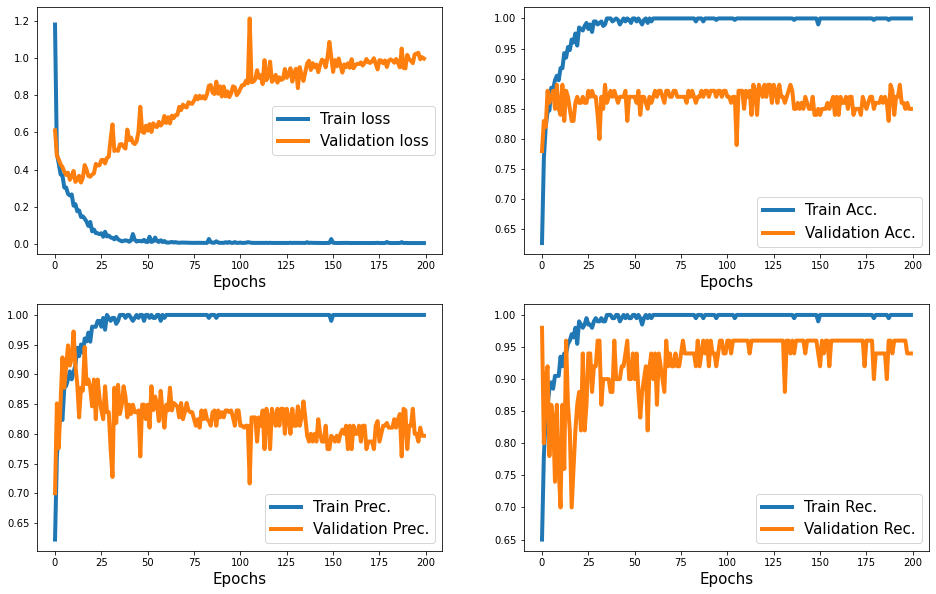

In [12]:
from mlxtend.plotting import plot_decision_regions

history = hist.history

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(2, 2, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(2, 2, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(2, 2, 3)
plt.plot(history['precision'], lw=4)
plt.plot(history['val_precision'], lw=4)
plt.legend(['Train Prec.', 'Validation Prec.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(2, 2, 4)
plt.plot(history['recall'], lw=4)
plt.plot(history['val_recall'], lw=4)
plt.legend(['Train Rec.', 'Validation Rec.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

plt.show()

##### Final thoughts:

The accuracy of our model started at 0.53 with our first attempt. After changing the learning rate and the regularization (L1) and adding additional dropout layers, we achieved 0.83 accuracy. There likely are some additional parameters that could be tuned more finely if we had more processing power available to us, but overall 0.83 is decent for our model. The plot of the loss is not what we expected; we expected the loss to decrease over the epochs for both train and validation, but we see the loss increase for validation. For the plots for accuracy, precision, and recall, the performance is generally better on the training set then the validation set; this suggests that our model is overfitting slightly to the training data. Overall, we think with further tuning and greater processing for faster model fitting, we could improve the performance, but 0.83 is a good accuracy.